<a href="https://colab.research.google.com/github/zhantia1/heart-disease-model/blob/main/Supervised_Learning_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project I am attempting to create a supervised learning model for predicting the leading indicators of heart disease. This information is very useful to healthcare professionals and even just anyone in general that wants to avoid heart disease. This model is trained using past heart disease data found on kaggle here: https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease

The code can also be found on github here: https://github.com/zhantia1/heart-disease-model

In [32]:
!pip install kaggle

First we import the dataset into this google colab. We will need a Kaggle API key which you can then place into your google drive for easy retrieval. The full instructions can be found here: https://saturncloud.io/blog/importing-datasets-from-kaggle-to-google-colab/

In [33]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
!kaggle datasets download -d kamilpytlak/personal-key-indicators-of-heart-disease

personal-key-indicators-of-heart-disease.zip: Skipping, found more recently modified local copy (use --force to force download)


In [35]:
import zipfile

file_path = 'personal-key-indicators-of-heart-disease.zip'

# # Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('heart-disease')  # Replace 'destination_folder' with your desired folder


The data analysis of the notebook starts here. We begin by doing some preliminary EDA. Examining the data with `df.head()` and `df.info()`.

In [36]:
import pandas as pd

df = pd.read_csv('heart-disease/2022/heart_2022_no_nans.csv')

df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.60,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No
1,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,No,...,1.78,95.25,30.13,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
2,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,"6 or more, but not all",No,...,1.85,108.86,31.66,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
3,Alabama,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.70,90.72,31.32,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
4,Alabama,Female,Good,3.0,15.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,No,...,1.55,79.38,33.07,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246022 entries, 0 to 246021
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      246022 non-null  object 
 1   Sex                        246022 non-null  object 
 2   GeneralHealth              246022 non-null  object 
 3   PhysicalHealthDays         246022 non-null  float64
 4   MentalHealthDays           246022 non-null  float64
 5   LastCheckupTime            246022 non-null  object 
 6   PhysicalActivities         246022 non-null  object 
 7   SleepHours                 246022 non-null  float64
 8   RemovedTeeth               246022 non-null  object 
 9   HadHeartAttack             246022 non-null  object 
 10  HadAngina                  246022 non-null  object 
 11  HadStroke                  246022 non-null  object 
 12  HadAsthma                  246022 non-null  object 
 13  HadSkinCancer              24

Cleaning up a lot of columns with object type as its data type. Using the below code snippet to check for unique values of a column:

unique_values = df['RemovedTeeth'].unique()

print(unique_values)

For now I will remove all the State data since it will be easier to visualize the correlations via a heatmap. I will add it back later since I'm curious whether it will have a significant effect once we run ensemble random forest on the model.

In [37]:
df["Sex"] = df["Sex"].map({'Male': 0, 'Female': 1})

health_mapping = {
    'Poor': 1,
    'Fair': 2,
    'Good': 3,
    'Very good': 4,
    'Excellent': 5
}
df['GeneralHealth'] = df['GeneralHealth'].map(health_mapping)

# use this mapping for all columns with No and Yes values
no_yes_mapping = {
    'No': 0,
    'Yes': 1
}

# these columns have No and Yes values
columns_with_no_yes = ['PhysicalActivities', 'HadHeartAttack', 'HadAngina', 'HadStroke',
                       'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder',
                       'HadKidneyDisease', 'HadArthritis', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
                       'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing',
                       'DifficultyErrands', 'ChestScan', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12',
                       'PneumoVaxEver', 'HighRiskLastYear', ]

# apply the conversion
for column in columns_with_no_yes:
    df[column] = df[column].map(no_yes_mapping)

# drop state for now. we will add it back later
df.drop('State', axis=1, inplace=True)

checkup_mapping = {
    'Within past year (anytime less than 12 months ago)': 4,
    'Within past 2 years (1 year but less than 2 years ago)': 3,
    'Within past 5 years (2 years but less than 5 years ago)': 2,
    '5 or more years ago': 1
}
df['LastCheckupTime'] = df['LastCheckupTime'].map(checkup_mapping)

teeth_mapping = {
    'None of them': 0,
    '1 to 5': 1,
    '6 or more, but not all': 2,
    'All': 3
}
df['RemovedTeeth'] = df['RemovedTeeth'].map(teeth_mapping)

diabetes_mapping = {
    'No': 0,
    'Yes': 1,
    'Yes, but only during pregnancy (female)': 2,
    'No, pre-diabetes or borderline diabetes': 3
}
df['HadDiabetes'] = df['HadDiabetes'].map(diabetes_mapping)

smoker_status_mapping = {
    'Never smoked': 0,
    'Former smoker': 1,
    'Current smoker - now smokes some days': 2,
    'Current smoker - now smokes every day': 3
}
df['SmokerStatus'] = df['SmokerStatus'].map(smoker_status_mapping)

ecig_usage_mapping = {
    'Never used e-cigarettes in my entire life': 0,
    'Not at all (right now)': 1,
    'Use them some days': 2,
    'Use them every day': 3
}
df['ECigaretteUsage'] = df['ECigaretteUsage'].map(ecig_usage_mapping)

# create dummy for each ethnicity group
df_encoded = pd.get_dummies(df['RaceEthnicityCategory'], prefix='Ethnicity')
df = pd.concat([df, df_encoded], axis=1)
df.drop('RaceEthnicityCategory', axis=1, inplace=True)

age_mapping = {
    'Age 18 to 24': 1,
    'Age 25 to 29': 2,
    'Age 30 to 34': 3,
    'Age 35 to 39': 4,
    'Age 40 to 44': 5,
    'Age 45 to 49': 6,
    'Age 50 to 54': 7,
    'Age 55 to 59': 8,
    'Age 60 to 64': 9,
    'Age 65 to 69': 10,
    'Age 70 to 74': 11,
    'Age 75 to 79': 12,
    'Age 80 or older': 13
}
df['AgeCategory'] = df['AgeCategory'].map(age_mapping)

tetanus_mapping = {
    'Yes, received Tdap': 3,
    'Yes, received tetanus shot but not sure what type': 2,
    'Yes, received tetanus shot, but not Tdap': 1,
    'No, did not receive any tetanus shot in the past 10 years': 0
}
df['TetanusLast10Tdap'] = df['TetanusLast10Tdap'].map(tetanus_mapping)

covid_pos_mapping = {
    'No': 0,
    'Yes': 1,
    'Tested positive using home test without a health professional': 2
}
df['CovidPos'] = df['CovidPos'].map(covid_pos_mapping)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246022 entries, 0 to 246021
Data columns (total 43 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   Sex                                      246022 non-null  int64  
 1   GeneralHealth                            246022 non-null  int64  
 2   PhysicalHealthDays                       246022 non-null  float64
 3   MentalHealthDays                         246022 non-null  float64
 4   LastCheckupTime                          246022 non-null  int64  
 5   PhysicalActivities                       246022 non-null  int64  
 6   SleepHours                               246022 non-null  float64
 7   RemovedTeeth                             246022 non-null  int64  
 8   HadHeartAttack                           246022 non-null  int64  
 9   HadAngina                                246022 non-null  int64  
 10  HadStroke                       

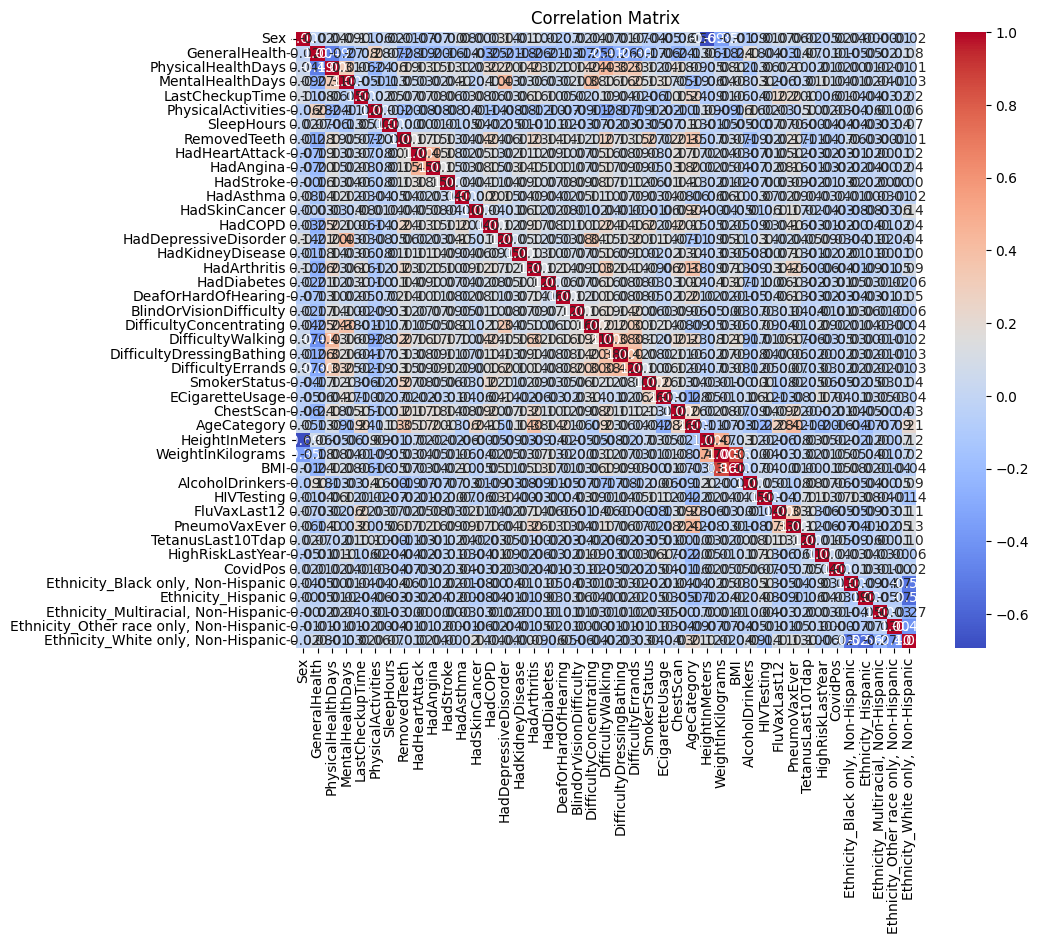

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

Since the plot above has too many dimensions and most do not appear to be correlated, we will add a cutoff threshold of 0.3 and redraw the correlation matrix.

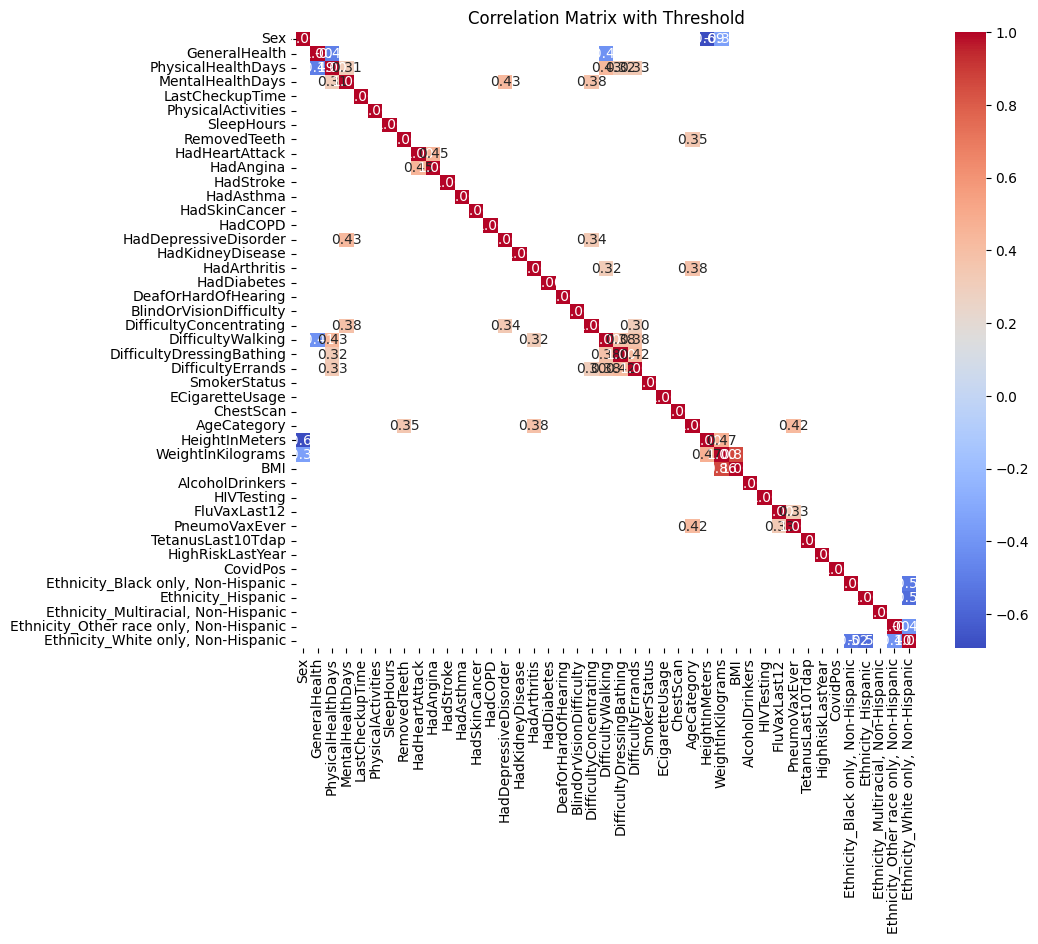

In [39]:
threshold = 0.3
filtered_corr = corr_matrix[abs(corr_matrix) >= threshold]
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, mask=filtered_corr.isnull())
plt.title('Correlation Matrix with Threshold')
plt.show()

It appears that only one dimension HadAngina made the cutoff for our dependent variable HadHeartDisease. It has a correlation of 0.45 which is not very high. In fact none of the the correlations between dimensions have are very high which signals that we should not have an issue with multicollinearity with these dimensions.

Next we add the states back in a binary variable for each state.

In [40]:
states_list = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
               'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia',
               'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
               'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
               'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
               'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota',
               'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
               'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia',
               'Washington', 'West Virginia', 'Wisconsin', 'Wyoming', 'Guam', 'Puerto Rico',
               'Virgin Islands']

df_new = pd.read_csv('heart-disease/2022/heart_2022_no_nans.csv')
df_encoded = pd.get_dummies(df_new['State'], dtype=int)
df_encoded = df_encoded.reindex(columns=states_list, fill_value=0)
df = pd.concat([df, df_encoded], axis=1)

df = df.dropna()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246022 entries, 0 to 246021
Data columns (total 97 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   Sex                                      246022 non-null  int64  
 1   GeneralHealth                            246022 non-null  int64  
 2   PhysicalHealthDays                       246022 non-null  float64
 3   MentalHealthDays                         246022 non-null  float64
 4   LastCheckupTime                          246022 non-null  int64  
 5   PhysicalActivities                       246022 non-null  int64  
 6   SleepHours                               246022 non-null  float64
 7   RemovedTeeth                             246022 non-null  int64  
 8   HadHeartAttack                           246022 non-null  int64  
 9   HadAngina                                246022 non-null  int64  
 10  HadStroke                       

Due to the high number of dimensions in the dataset, I believe a good model would be an ensemble method using Random Forest. Random Forest is great at handling large dimensions so we will proceed to build our model using Random Forest.

Now that we've cleaned up all the data for regressional analysis, we can split our data into training and test data. I decided to use a test size split of 0.3 for this model.

In [41]:
from sklearn.model_selection import train_test_split

X = df.drop('HadHeartAttack', axis=1)
y = df['HadHeartAttack']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [42]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [43]:
from sklearn.metrics import accuracy_score, classification_report

# predict on the testing set
y_pred = rf_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9482975869497473
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     69809
           1       0.61      0.13      0.21      3998

    accuracy                           0.95     73807
   macro avg       0.78      0.56      0.59     73807
weighted avg       0.93      0.95      0.93     73807



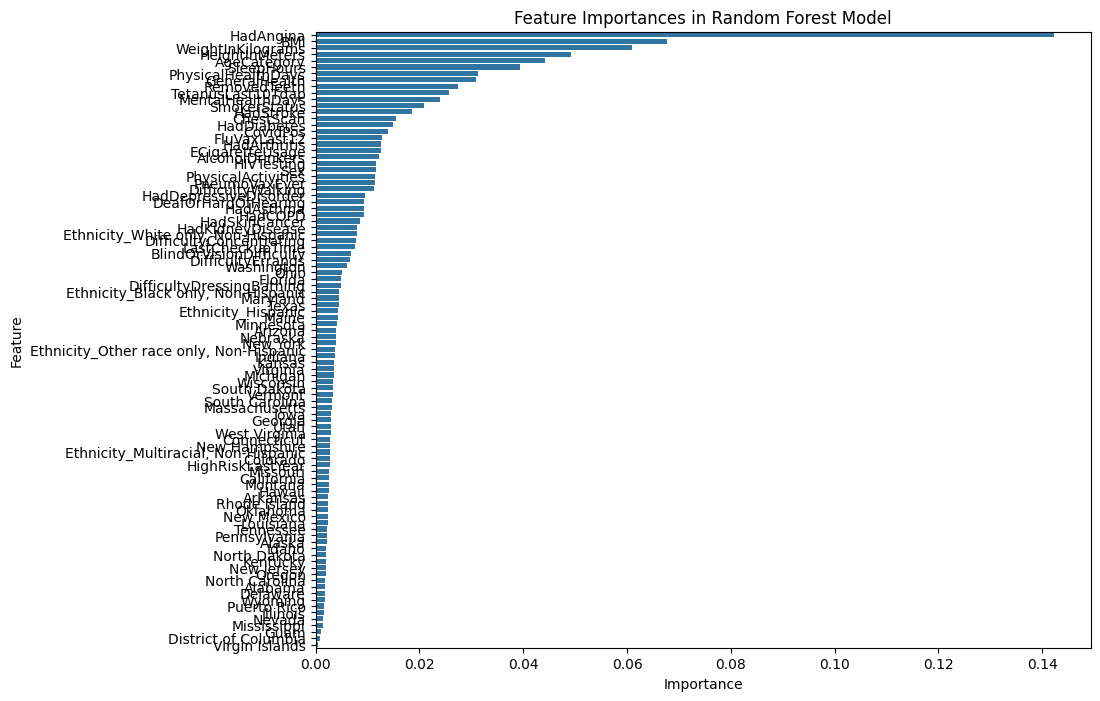

In [44]:
importances = rf_classifier.feature_importances_

feature_names = X_train.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances in Random Forest Model')
plt.show()

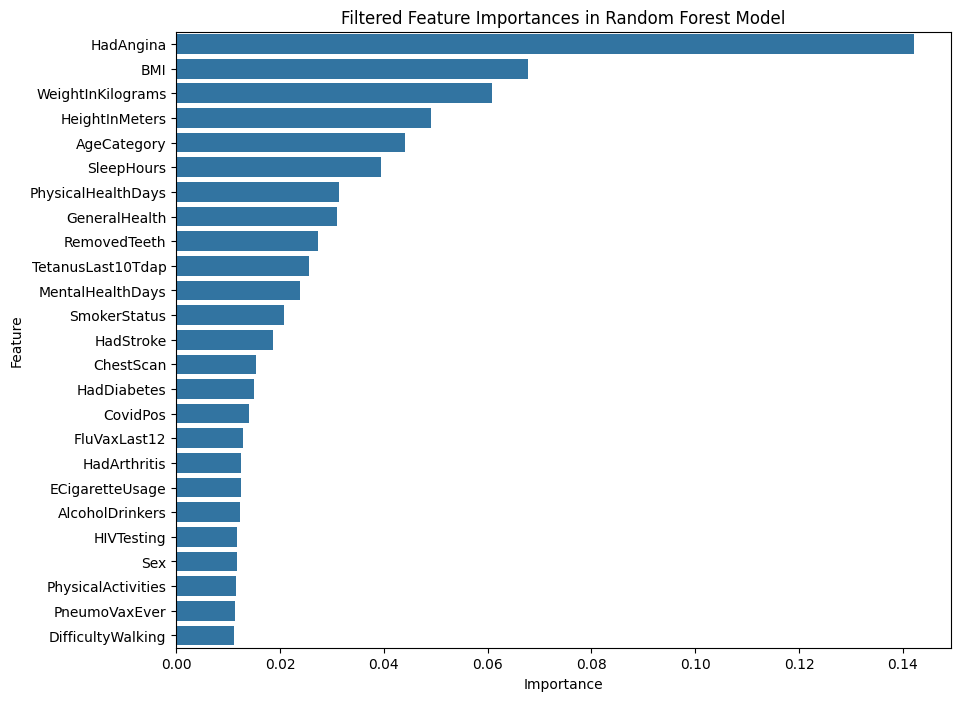

In [45]:
threshold = 0.01  # only keep features with importance greater than 0.01
filtered_importances = feature_importances[feature_importances['Importance'] > threshold]
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=filtered_importances.sort_values(by='Importance', ascending=False))
plt.title('Filtered Feature Importances in Random Forest Model')
plt.show()

Next, instead of guessing the hyperparameter to give to our random forest model, we use a programmatic approach to calculate the most optimal model.

Note: This takes a very long time to run.

In [18]:
from sklearn.model_selection import GridSearchCV, train_test_split

# programatically optimize the model
rf_classifier = RandomForestClassifier()

# grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [None, 5, 10],       # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required at each leaf node
}

# perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the best model on the test set
best_rf_model = grid_search.best_estimator_
test_accuracy = best_rf_model.score(X_test, y_test)

# predict on the testing set
y_pred = best_rf_model.predict(X_test)

print("Test accuracy of the best model:", test_accuracy)
print(classification_report(y_test, y_pred))

KeyboardInterrupt: 